In [ ]:
!wget https://github.com/official-stockfish/Stockfish/releases/latest/download/stockfish-ubuntu-x86-64.tar

In [1]:
ls

A2roll_20_alpha_beta.ipynb  A2roll_20_MCTS.ipynb  stockfish/


In [ ]:
!tar -xvf stockfish-ubuntu-x86-64.tar

In [4]:
!pwd
!ls

/home/mahmud/Labs/AILAB
Lab02  Lab03  stockfish  stockfish-ubuntu-x86-64.tar


In [10]:
!pip install chess

In [1]:
# Importing standard libraries
import os  # For interacting with the operating system
import random  # For generating random numbers
import time  # For time-related functions

# Importing mathematical functions
from math import log, sqrt, e, inf

# Importing visualization libraries
import matplotlib.pyplot as plt  # For plotting graphs
from IPython.display import display, clear_output  # For displaying outputs in Jupyter Notebooks
from tqdm import tqdm  # For displaying progress bars

# Importing chess-related libraries
import chess  # For chessboard and move handling
import chess.svg  # For rendering chessboard as SVG
import chess.pgn  # For handling Portable Game Notation (PGN)
import chess.engine  # For interfacing with chess engines


In [2]:
# Function to plot values
def plot_values(V):
    """
    Plots a graph of the input values.

    Parameters:
    V (list or array-like): A list or array of values to be plotted.

    The function plots the values in V against their index, labeling the x-axis as 'Turn'
    and the y-axis as 'Time (sec)'. The plot includes grid lines for better readability.
    """
    # Set the figure size
    plt.figure(figsize=(8, 6))

    # Plot the values in V
    plt.plot(V)

    # Set the title of the plot
    plt.title('Turn vs Time')

    # Label the x-axis
    plt.xlabel('Turn')

    # Label the y-axis
    plt.ylabel('Time (sec)')

    # Enable grid lines
    plt.grid(True)

    # Display the plot
    plt.show()

In [3]:
# CONSTANTS
c = 2
eps = 10**-7

In [4]:
# Define the node class
class node():
    def __init__(self):
        """
        Initialize a new node for the game tree.
        """
        # Initialize the state of the node with a new chess board
        self.state = chess.Board()  

        # Initialize the action that led to this node (empty string for root node)
        self.action = ''

        # Initialize an empty set to hold children nodes
        self.children = set()

        # Initialize the parent node to None
        self.parent = None

        # Initialize the visit count of the node in the current tree
        self.N = 0

        # Initialize the visit count of the node in the overall tree
        self.n = 0

        # Initialize the value of the node
        self.v = 0


In [5]:
def ucb1(curr_node):
    """
    Calculate the Upper Confidence Bound 1 (UCB1) value for a given node.
    
    Parameters:
    curr_node (node): The current node for which the UCB1 value is to be calculated.
    
    Returns:
    float: The UCB1 value of the current node.
    """
    # Calculate the exploration term
    exploration_term = 2 * sqrt(log(curr_node.N + e + (10**-6)) / (curr_node.n + (10**-10)))
    
    # Calculate the UCB1 value as the sum of the node value and the exploration term
    ans = curr_node.v + exploration_term
    
    return ans


In [6]:
def load_engine():
    file_name = 'stockfish-ubuntu-x86-64'
    return chess.engine.SimpleEngine.popen_uci(os.path.abspath('stockfish/'+file_name))

In [7]:
def rollback(curr_node, reward):
    """
    Update the node values and propagate the reward up the tree.

    Parameters:
    curr_node (node): The current node from which the rollback starts.
    reward (float): The reward to be propagated up the tree.

    Returns:
    node: The root node after updating the visit counts and values.
    """
    # Update the current node's visit count and value
    curr_node.n += 1
    curr_node.v += reward

    # Propagate the changes up the tree until reaching the root node
    while curr_node.parent is not None:
        curr_node.N += 1  # Increment the parent's visit count
        curr_node = curr_node.parent  # Move to the parent node

    # Once at the root node, increment its visit count
    curr_node.N += 1

    return curr_node

In [8]:
def rollout(curr_node):
    """
    Perform a rollout (simulation) from the current node.

    Parameters:
    curr_node (node): The current node from which the rollout starts.

    Returns:
    tuple: A tuple containing the result of the game and the final node reached.
           The result is 1 for a win, -1 for a loss, and 0.5 for a draw.
    """
    # Check if the game is over at the current node
    if curr_node.state.is_game_over():
        board = curr_node.state
        if board.result() == '1-0':
            return (1, curr_node)  # Return 1 for a win
        elif board.result() == '0-1':
            return (-1, curr_node)  # Return -1 for a loss
        else:
            return (0.5, curr_node)  # Return 0.5 for a draw

    # Get all legal moves in Standard Algebraic Notation (SAN)
    all_moves = [curr_node.state.san(i) for i in list(curr_node.state.legal_moves)]

    # Expand the current node by generating child nodes for each legal move
    for i in all_moves:
        tmp_state = chess.Board(curr_node.state.fen())  # Create a copy of the current board state
        tmp_state.push_san(i)  # Make the move on the copied board
        child = node()  # Create a new node for the child
        child.state = tmp_state  # Set the state of the child node
        child.parent = curr_node  # Set the parent of the child node
        curr_node.children.add(child)  # Add the child node to the children set

    # Select a random child node
    rnd_state = random.choice(list(curr_node.children))

    # Recursively perform rollout on the selected child node
    return rollout(rnd_state)

In [9]:
def expand(curr_node, white):
    """
    Expand the search tree from the current node based on the UCB1 values.

    Parameters:
    curr_node (node): The current node from which to start expansion.
    white (bool): A boolean indicating if it's white's turn to move.

    Returns:
    node: The selected node after expansion.
    """
    # If the current node has no children, return the current node
    if len(curr_node.children) == 0:
        return curr_node

    # Initialize variables for selecting the child node based on UCB1 values
    max_ucb = -inf
    min_ucb = inf
    sel_child = None

    # If it's white's turn, select the child node with the maximum UCB1 value
    if white:
        for child in curr_node.children:
            tmp = ucb1(child)  # Calculate UCB1 value for the child node
            if tmp > max_ucb:
                max_ucb = tmp
                sel_child = child

        # Recursively expand from the selected child node for black's turn
        return expand(sel_child, False)

    # If it's black's turn, select the child node with the minimum UCB1 value
    else:
        for child in curr_node.children:
            tmp = ucb1(child)  # Calculate UCB1 value for the child node
            if tmp < min_ucb:
                min_ucb = tmp
                sel_child = child

        # Recursively expand from the selected child node for white's turn
        return expand(sel_child, True)

In [10]:
def mcts_pred(curr_node, over, white, iterations=10):
    """
    Perform Monte Carlo Tree Search (MCTS) to predict the best move.

    Parameters:
    curr_node (node): The current node from which to start the MCTS.
    over (bool): A boolean indicating if the game is over.
    white (bool): A boolean indicating if it's white's turn to move.
    iterations (int): The number of iterations to perform for the MCTS. Default is 10.

    Returns:
    str: The best move in SAN (Standard Algebraic Notation).
    """
    # If the game is over, return -1 indicating no move
    if over:
        return -1

    # Generate all legal moves in SAN and map each child node to its corresponding move
    all_moves = [curr_node.state.san(i) for i in list(curr_node.state.legal_moves)]
    map_state_move = dict()
    
    for move in all_moves:
        tmp_state = chess.Board(curr_node.state.fen())  # Copy the current board state
        tmp_state.push_san(move)  # Make the move on the copied board
        child = node()  # Create a new node for the child
        child.state = tmp_state  # Set the state of the child node
        child.parent = curr_node  # Set the parent of the child node
        curr_node.children.add(child)  # Add the child node to the set of children
        map_state_move[child] = move  # Map the child node to its corresponding move
    
    # Perform MCTS for the specified number of iterations
    while iterations > 0:
        if white:
            max_ucb = -inf
            sel_child = None
            for child in curr_node.children:
                tmp = ucb1(child)  # Calculate UCB1 value for the child node
                if tmp > max_ucb:
                    max_ucb = tmp
                    sel_child = child

            ex_child = expand(sel_child, False)  # Expand the selected child node
            reward, state = rollout(ex_child)  # Perform a rollout from the expanded node
            curr_node = rollback(state, reward)  # Backpropagate the reward
        else:
            min_ucb = inf
            sel_child = None
            for child in curr_node.children:
                tmp = ucb1(child)  # Calculate UCB1 value for the child node
                if tmp < min_ucb:
                    min_ucb = tmp
                    sel_child = child

            ex_child = expand(sel_child, True)  # Expand the selected child node
            reward, state = rollout(ex_child)  # Perform a rollout from the expanded node
            curr_node = rollback(state, reward)  # Backpropagate the reward

        iterations -= 1

    # Select the best move based on the final UCB1 values
    if white:
        mx = -inf
        selected_move = ''
        for child in curr_node.children:
            tmp = ucb1(child)
            if tmp > mx:
                mx = tmp
                selected_move = map_state_move[child]
        return selected_move
    else:
        mn = inf
        selected_move = ''
        for child in curr_node.children:
            tmp = ucb1(child)
            if tmp < mn:
                mn = tmp
                selected_move = map_state_move[child]
        return selected_move

In [12]:
# Initialize the chess board
board = chess.Board()

# Set up variables and lists for tracking game progress and evaluations
white = 1  # Indicator for white's turn
moves = 0  # Counter for total moves
pgn = []   # List to store moves in Standard Algebraic Notation (SAN)
evaluations = []  # List to store evaluations (if needed)
sm = 0     # Variable to accumulate total time taken for moves
cnt = 0    # Counter for the number of iterations
itr = 10   # Number of iterations (moves) to perform
time_delta = []  # List to store time taken per move

# Perform MCTS for a specified number of iterations
for _ in tqdm(range(itr)):
    # Generate all legal moves in SAN
    all_moves = [board.san(i) for i in list(board.legal_moves)]
    start = time.time()  # Start timing for move
    root = node()  # Initialize the root node for MCTS
    root.state = board  # Set the state of the root node to the current board position
    result = mcts_pred(root, board.is_game_over(), white)  # Perform MCTS to get the best move
    t = time.time() - start  # Calculate time taken for the move
    sm += t  # Accumulate total time
    time_delta.append(t)  # Record time taken for this move
    board.push_san(result)  # Make the best move on the board
    pgn.append(result)  # Add the move to the list of moves
    white ^= 1  # Toggle the indicator for the next turn
    cnt += 1  # Increment move counter
    clear_output(wait=True)  # Clear the output for better display
    moves += 1  # Increment total moves
    
    # Print the latest move and the current board position
    print(result)
    print(board)

# Calculate and print average time per move
print("Average Time per move = ", sm / cnt)

# Print the list of moves in Standard Algebraic Notation (SAN)
print(" ".join(pgn))

# Print the result of the game
print(board.result())

# End of game

100%|███████████████████████████████████████████| 10/10 [04:23<00:00, 26.36s/it]

Ng4
r n b q k b . r
. . p p p p p p
. p . . . . . .
. . . . . . . .
. p B . . . n .
. . . . P . P .
P . P P Q P . P
R N B . K . N R
Average Time per move =  26.356986021995546
b4 Nf6 e3 a5 Bc4 b6 Qe2 axb4 g3 Ng4
*


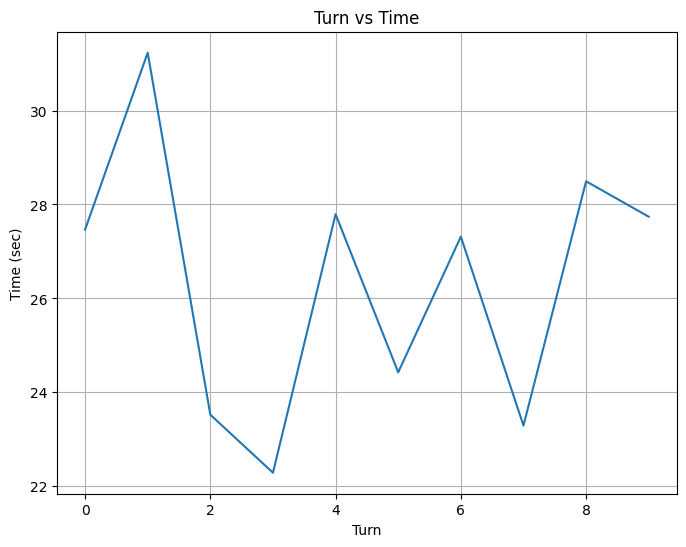

In [13]:
plot_values(time_delta)

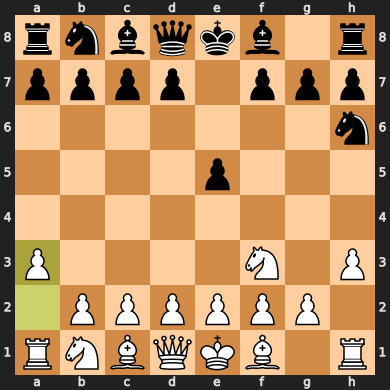

In [18]:
board